---
title: "Quality Control Analysis"
author: "Mary Piper, Lorena Pantano, Meeta Mistry, Radhika Khetani, Jihe Liu"
date: Monday, February 24th, 2020
---

Approximate time: 90 minutes

## Learning Objectives:

* Construct quality control metrics and visually evaluate the quality of the data
* Apply appropriate filters to remove low quality cells

# Single-cell RNA-seq: Quality control


<img src="../img/sc_workflow_2022.jpg" width="630">


***

Each step of this workflow has its own goals and challenges. For QC of our raw count data, they include:

_**Goals:**_ 
 
 - _To **filter the data to only include true cells that are of high quality**, so that when we cluster our cells it is easier to identify distinct cell type populations_
 - _To **identify any failed samples** and either try to salvage the data or remove from analysis, in addition to, trying to understand why the sample failed_

_**Challenges:**_
 
 - _Delineating cells that are **poor quality from less complex cells**_
 - _Choosing appropriate thresholds for filtering, so as to **keep high quality cells without removing biologically relevant cell types**_

_**Recommendations:**_
 
 - _Have a good idea of your expectations for the **cell types to be present** prior to performing the QC. For instance, do you expect to have low complexity cells or cells with higher levels of mitochondrial expression in your sample? If so, then we need to account for this biology when assessing the quality of our data._

***

## Generating quality metrics

When data is loaded into Seurat and the initial object is created, there is some basic metadata asssembled for each of the cells in the count matrix. To take a close look at this metadata, let's view the data frame stored in the `obs` slot of our `adata` object:


In [87]:
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

adata = sc.read_h5ad("../results/03_merge.h5ad")
adata.obs.head()

,n_genes,sample
AAACATACAATGCC-1_ctrl,874,ctrl
AAACATACATTTCC-1_ctrl,896,ctrl
AAACATACCAGAAA-1_ctrl,725,ctrl
AAACATACCAGCTA-1_ctrl,979,ctrl
AAACATACCATGCA-1_ctrl,362,ctrl


In order to create the appropriate plots for the quality control analysis, we need to calculate some additional metrics. These include:

- **Number of counts per cell** total counts in a cell
- **Number of genes detected per UMI:** this metric with give us an idea of the complexity of our dataset (more genes detected per UMI, more complex our data)
- **Mitochondrial ratio:** this metric will give us a percentage of cell reads originating from the mitochondrial genes

To calculate these values, we can use the `calculate_qc_metrics()` function to automatically generate scores for each cell.

In [88]:
sc.pp.calculate_qc_metrics(adata,
                           percent_top=None,
                           log1p=False,
                           inplace=True)
adata.obs.head()

,n_genes,sample,n_genes_by_counts,total_counts
AAACATACAATGCC-1_ctrl,874,ctrl,874,2344.0
AAACATACATTTCC-1_ctrl,896,ctrl,896,3125.0
AAACATACCAGAAA-1_ctrl,725,ctrl,725,2578.0
AAACATACCAGCTA-1_ctrl,979,ctrl,979,3261.0
AAACATACCATGCA-1_ctrl,362,ctrl,362,746.0


# Assessing the quality metrics

Now that we have generated the various metrics to assess, we can explore them with visualizations. We will assess various metrics and then decide on which cells are low quality and should be removed from the analysis:

- Cell counts
- UMI counts per cell
- Genes detected per cell
- Complexity (novelty score)
- Mitochondrial counts ratio


::: callout-note
# What about doublets?

In single-cell RNA sequencing experiments, doublets are generated from two cells. They typically arise due to errors in cell sorting or capture, especially in droplet-based protocols involving thousands of cells. Doublets are obviously undesirable when the aim is to characterize populations at the single-cell level. In particular, they can incorrectly suggest the existence of intermediate populations or transitory states that do not actually exist. Thus, it is desirable to remove doublet libraries so that they do not compromise interpretation of the results.
:::

::: callout-note
# Why aren't we checking for doublets? 
Many workflows use maximum thresholds for UMIs or genes, with the idea that a much higher number of reads or genes detected indicate multiple cells. While this rationale seems to be intuitive, it is not accurate. Also, many of the tools used to detect doublets tend to get rid of cells with intermediate or continuous phenotypes, although they may work well on datasets with very discrete cell types. [Scrublet](https://github.com/AllonKleinLab/scrublet) is a popular tool for doublet detection, but we haven't adequately benchmarked it yet. Currently, we recommend not including any thresholds at this point in time. When we have identified markers for each of the clusters, we suggest exploring the markers to determine whether the markers apply to more than one cell type.
:::

## Cell counts

The cell counts are determined by the number of unique cellular barcodes detected. For this experiment, between 12,000 -13,000 cells are expected.

In an ideal world, you would expect the number of unique cellular barcodes to correpsond to the number of cells you loaded. However, this is not the case as capture rates of cells are only a proportion of what is loaded. For example, the inDrops cell **capture efficiency** is higher (70-80%) compared to 10X which is between 50-60%.

::: callout-note
The capture efficiency could appear much lower if the cell concentration used for library preparation was not accurate. Cell concentration should NOT be determined by FACS machine or Bioanalyzer (these tools are not accurate for concentration determination), instead use a hemocytometer or automated cell counter for calculation of cell concentration._
:::

The cell numbers can also vary by protocol, **producing cell numbers that are much higher than what we loaded**. For example, during the inDrops protocol, the cellular barcodes are present in the hydrogels, which are encapsulated in the droplets with a single cell and lysis/reaction mixture. While each hydrogel should have a single cellular barcode associated with it, occasionally a hydrogel can have more than one cellular barcode. Similarly, with the 10X protocol there is a chance of obtaining only a barcoded bead in the emulsion droplet (GEM) and no actual cell.  Both of these, in addition to the presence of dying cells can lead to a higher number of cellular barcodes than cells.

Text(0.5, 1.0, 'NCells')

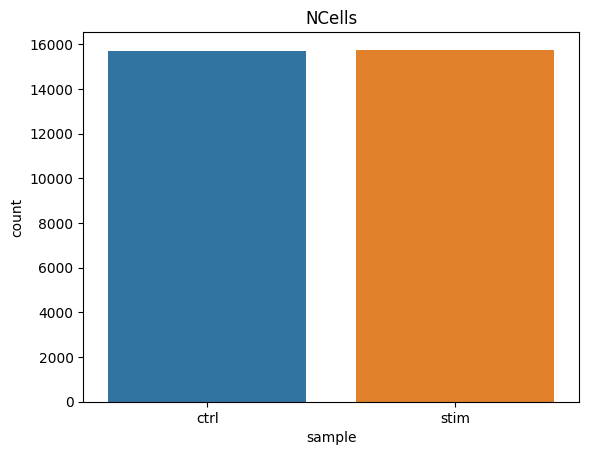

In [90]:
ax = sns.countplot(data=adata.obs, 
                   x="sample",
                   hue="sample")
ax.set_title("NCells")

We see over 15,000 cells per sample, which is quite a bit more than the 12-13,000 expected. It is clear that we likely have some junk 'cells' present.

## UMI counts (transcripts) per cell

The UMI counts per cell should generally be above 500, that is the low end of what we expect. If UMI counts are between 500-1000 counts, it is usable but the cells probably should have been sequenced more deeply. 

Text(0.5, 1.0, 'Total Counts')

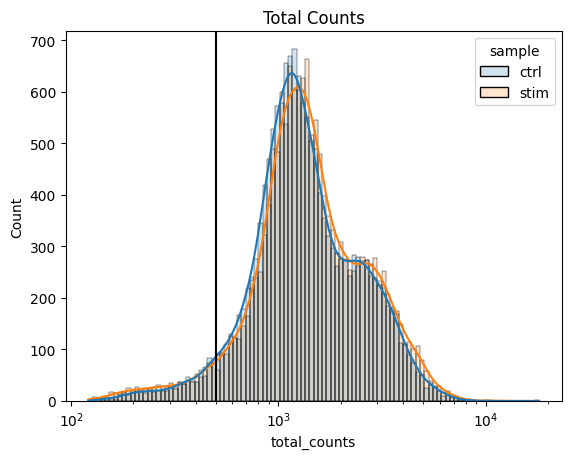

In [91]:
ax = sns.histplot(data=adata.obs,
                  x="total_counts",
                  hue="sample",
                  kde=True,
                  log_scale=True,
                  alpha=0.2)
ax.axvline(500, color="black")
ax.set_title("Total Counts")

We can see that majority of our cells in both samples have 1000 UMIs or greater, which is great. 


### Genes detected per cell

We have similar expectations for gene detection as for UMI detection, although it may be a bit lower than UMIs. For high quality data, the proportional histogram should contain **a single large peak that represents cells that were encapsulated**. If we see a **small shoulder** to the left of the major peak (not present in our data), or a bimodal distribution of the cells, that can indicate a couple of things. It might be that there are a set of **cells that failed** for some reason. It could also be that there are **biologically different types of cells** (i.e. quiescent cell populations, less complex cells of interest), and/or one type is much smaller than the other (i.e. cells with high counts may be cells that are larger in size). Therefore, this threshold should be assessed with other metrics that we describe in this lesson.


Text(0.5, 1.0, 'Genes per Cell')

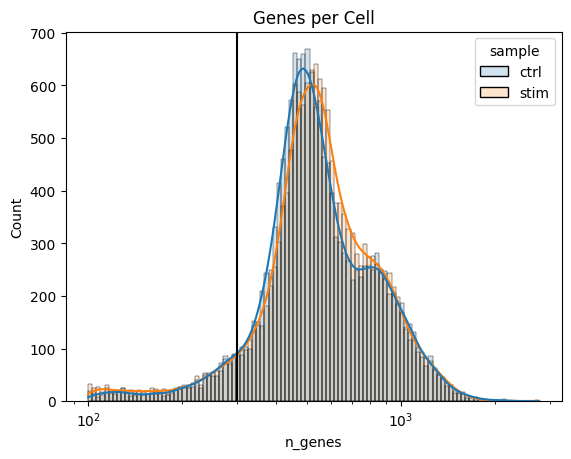

In [37]:
ax = sns.histplot(data=adata.obs,
                  x="n_genes",
                  hue="sample",
                  kde=True,
                  log_scale=True,
                  alpha=0.2)
ax.axvline(300, color="black")
ax.set_title("Genes per Cell")

### Complexity

We can evaluate each cell in terms of how complex the RNA species are by using a measure called the novelty score. The novelty score is computed by taking the ratio of nGenes over nUMI. If there are many captured transcripts (high nUMI) and a low number of genes detected in a cell, this likely means that you only captured a low number of genes and simply sequenced transcripts from those lower number of genes over and over again. These low complexity (low novelty) cells could represent a specific cell type (i.e. red blood cells which lack a typical transcriptome), or could be due to an artifact or contamination. Generally, we expect the novelty score to be above 0.80 for good quality cells.


In [92]:
adata.obs["log10GenesPerUMI"] = np.log10(adata.obs["n_genes"]) / np.log10(adata.obs["total_counts"])
adata.obs.head()

,n_genes,sample,n_genes_by_counts,total_counts,log10GenesPerUMI
AAACATACAATGCC-1_ctrl,874,ctrl,874,2344.0,0.872863
AAACATACATTTCC-1_ctrl,896,ctrl,896,3125.0,0.844760
AAACATACCAGAAA-1_ctrl,725,ctrl,725,2578.0,0.838493
AAACATACCAGCTA-1_ctrl,979,ctrl,979,3261.0,0.851262
AAACATACCATGCA-1_ctrl,362,ctrl,362,746.0,0.890686


Text(0.5, 1.0, 'Genes per Cell')

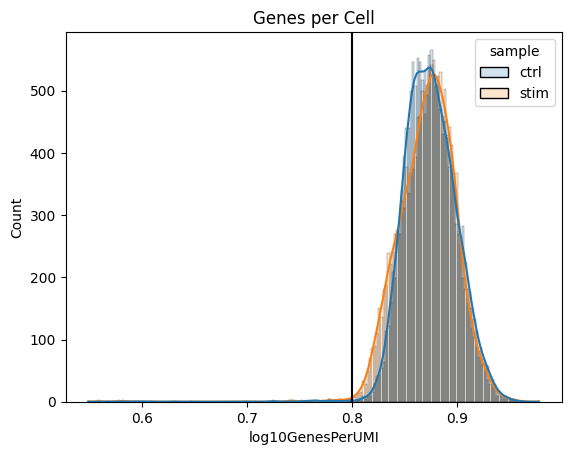

In [93]:
ax = sns.histplot(data=adata.obs,
                  x="log10GenesPerUMI",
                  hue="sample",
                  kde=True,
                  alpha=0.2)
ax.axvline(0.8, color="black")
ax.set_title("Genes per Cell")

### Mitochondrial Ratio

Seurat has a convenient function that allows us to calculate the **proportion of transcripts mapping to mitochondrial genes**. The `PercentageFeatureSet()` function takes in a `pattern` argument and searches through all gene identifiers in the dataset for that pattern. Since we are looking for mitochondrial genes, we are searching any gene identifiers that begin with the pattern "MT-". For each cell, the function takes the sum of counts across all genes (features) belonging to the "Mt-" set, and then divides by the count sum for all genes (features). This value is multiplied by 100 to obtain a percentage value. 

::: callout-note
For our analysis, rather than using a percentage value we would prefer to work with the ratio value. As such, we will reverse that last step performed by the function by taking the output value and dividing by 100.
:::


In [95]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.var['mito'] = mito_genes
adata.var.head()

,gene_ids,feature_types,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mito
MIR1302-2HG,ENSG00000243485,Gene Expression,0,0.000000,100.000000,0.0,False
FAM138A,ENSG00000237613,Gene Expression,0,0.000000,100.000000,0.0,False
OR4F5,ENSG00000186092,Gene Expression,0,0.000000,100.000000,0.0,False
AL627309.1,ENSG00000238009,Gene Expression,12,0.000382,99.961837,12.0,False
AL627309.3,ENSG00000239945,Gene Expression,1,0.000032,99.996820,1.0,False


::: callout-note
The pattern provided ("^MT-") works for human gene names. You may need to adjust the pattern argument depending on your organism of interest. Additionally, if you weren't using gene names as the gene ID then this function wouldn't work as we have used it above as the pattern will not suffice. Since there are caveats to using this function, it is advisable to manually compute this metric. If you are interested, we have [code available to compute this metric on your own](https://github.com/hbctraining/scRNA-seq/blob/master/lessons/mitoRatio.md).
:::


In [96]:
sc.pp.calculate_qc_metrics(adata, 
                           qc_vars=("mito"), 
                           inplace=True)
adata.obs.head()

,n_genes,sample,n_genes_by_counts,total_counts,log10GenesPerUMI,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito
AAACATACAATGCC-1_ctrl,874,ctrl,874,2344.0,0.872863,6.774224,7.760041,47.568259,59.129693,69.197952,84.044369,46.0,3.850147,1.962457
AAACATACATTTCC-1_ctrl,896,ctrl,896,3125.0,0.844760,6.799056,8.047509,51.904000,63.456000,74.080000,87.328000,56.0,4.043051,1.792000
AAACATACCAGAAA-1_ctrl,725,ctrl,725,2578.0,0.838493,6.587550,7.855157,61.947246,69.550039,78.432894,91.272304,40.0,3.713572,1.551590
AAACATACCAGCTA-1_ctrl,979,ctrl,979,3261.0,0.851262,6.887553,8.090096,52.836553,62.557498,71.879791,85.311254,45.0,3.828641,1.379945
AAACATACCATGCA-1_ctrl,362,ctrl,362,746.0,0.890686,5.894403,6.616065,53.887399,64.879357,78.284182,100.000000,16.0,2.833213,2.144772


Text(0.5, 1.0, 'Mitochondrial Ratio')

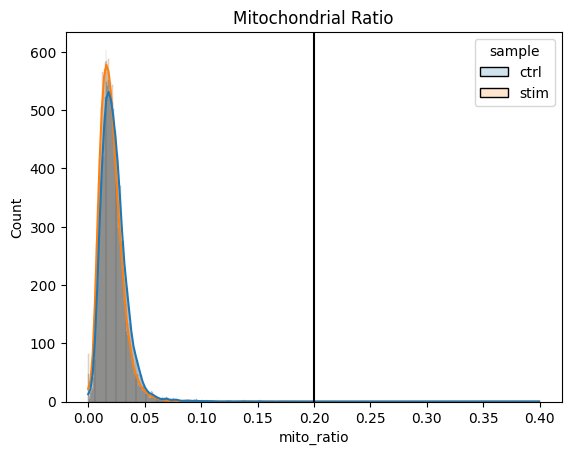

In [97]:
# We want the value as a ratio
adata.obs["mito_ratio"] = adata.obs["pct_counts_mito"] / 100

ax = sns.histplot(data=adata.obs,
                  x="mito_ratio",
                  hue="sample",
                  kde=True,
                  alpha=0.2)
ax.axvline(0.2, color="black")
ax.set_title("Mitochondrial Ratio")

::: callout-note
# Reads per cell
This is another metric that can be useful to explore; however, the workflow used would need to save this information to assess. Generally, with this metric you hope to see all of the samples with peaks in relatively the same location between 10,000 and 100,000 reads per cell. 
:::

### Joint filtering effects

Considering any of these QC metrics in isolation can lead to misinterpretation of cellular signals. For example, cells with a comparatively high fraction of mitochondrial counts may be involved in respiratory processes and may be cells that you would like to keep. Likewise, other metrics can have other biological interpretations.  A general rule of thumb when performing QC is to **set thresholds for individual metrics to be as permissive as possible, and always consider the joint effects** of these metrics. In this way, you reduce the risk of filtering out any viable cell populations. 


Two metrics that are often evaluated together are the number of UMIs and the number of genes detected per cell. Here, we have plotted the **number of genes versus the number of UMIs coloured by the fraction of mitochondrial reads**. Jointly visualizing the count and gene thresholds and additionally overlaying the mitochondrial fraction, gives a summarized persepective of the quality per cell.


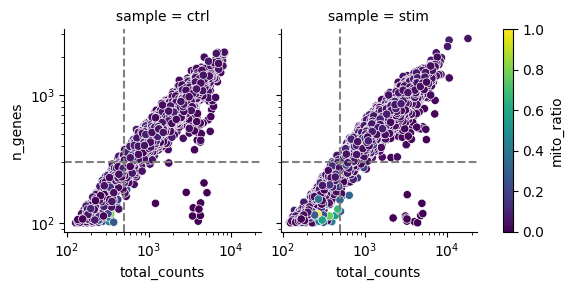

In [99]:
g = sns.FacetGrid(adata.obs, col="sample")
g.map_dataframe(sns.scatterplot, 
                x="total_counts", 
                y="n_genes", 
                hue="mito_ratio",
                palette="viridis")

# Log10 scale x- and y-axis
for ax in g.axes.flat:
    ax.set(xscale="log", yscale="log")

# Add lines
g.refline(x=500, y=300)

# Add colorbar legend
sm = g.axes[0, 0].collections[0]
plt.colorbar(sm, 
             ax=g.axes, 
             label="mito_ratio")